***Importing Libraries***

In [ ]:
import numpy as np
from glob import glob
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

In [ ]:
human_files = np.array(glob("/gdrive/My Drive/Deep Learning Project/lfw/*/*"))
dog_files = np.array(glob("/gdrive/My Drive/Deep Learning Project/dogImages/*/*/*"))

In [ ]:
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8356 total dog images.


In [ ]:
face_cascade = cv2.CascadeClassifier('/gdrive/My Drive/Deep Learning Project/haarcascade_frontalface_alt.xml')


Number of faces detected: 1


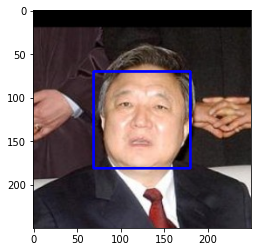

In [ ]:
img = cv2.imread(human_files[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

In [ ]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

In [ ]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [ ]:
def percentageOfDetectingFaces(detector, img_paths):
    count = 0
    for img_path in img_paths:
        if detector(img_path):
            count += 1
    return count / len(img_paths) * 100

print("The percentage of the human images that include a detected, human face: {}%.".format(percentageOfDetectingFaces(face_detector, human_files_short)))
print("The percentage of the dog images that include a detected, human face: {}%.".format(percentageOfDetectingFaces(face_detector, dog_files_short)))

The percentage of the human images that include a detected, human face: 99.0%.
The percentage of the dog images that include a detected, human face: 6.0%.


### Detecting Dogs

In [ ]:
import torch
import torchvision.models as models

VGG16 = models.vgg16(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    VGG16 = VGG16.cuda()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### Making Predictions with a Pre-trained Model

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
def VGG16_predict(img_path):
  img = Image.open(img_path) 
  transform = transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor()]) 
  img_tensor = transform(img)
  img_tensor.unsqueeze_(0)
  if use_cuda:
    img_tensor = img_tensor.cuda()
    prediction = VGG16(img_tensor)
  if use_cuda:
     prediction = prediction.cpu()
     return prediction.data.numpy().argmax()

In [ ]:
def dog_detector(img_path):
    index = VGG16_predict(img_path)
    return index >= 151 and index <= 268

In [ ]:
print("The percentage of the human images that include a detected, dog face: {}%.".format(percentageOfDetectingFaces(dog_detector, human_files_short)))
print("The percentage of the dog images that include a detected, dog face: {}%.".format(percentageOfDetectingFaces(dog_detector, dog_files_short)))

The percentage of the human images that include a detected, dog face: 0.0%.
The percentage of the dog images that include a detected, dog face: 96.0%.


### Creating a CNN model to classify Dog Breeds

In [ ]:
import os
from torchvision import datasets
data_dir = '/gdrive/My Drive/Deep Learning Project/dogImages'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(), 
                                    transforms.RandomRotation(10),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  6685
Num valid images:  835
Num test images:  836


In [ ]:
batch_size = 20
num_workers=0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=num_workers, shuffle=True)

### Model Architecture


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 133)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_scratch = Net()
print(model_scratch)

if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
import torch.optim as optim
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

### Train and Validate the Model


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
          if use_cuda:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss,valid_loss))

        if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
          torch.save(model.state_dict(), save_path)
          valid_loss_min = valid_loss
    return model

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch,criterion_scratch, use_cuda, 'model_scratch.pt')
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.523250 	Validation Loss: 4.502476
Validation loss decreased (inf --> 4.502476).  Saving model ...
Epoch: 2 	Training Loss: 4.480023 	Validation Loss: 4.456006
Validation loss decreased (4.502476 --> 4.456006).  Saving model ...
Epoch: 3 	Training Loss: 4.409727 	Validation Loss: 4.429330
Validation loss decreased (4.456006 --> 4.429330).  Saving model ...
Epoch: 4 	Training Loss: 4.377593 	Validation Loss: 4.407836
Validation loss decreased (4.429330 --> 4.407836).  Saving model ...
Epoch: 5 	Training Loss: 4.293640 	Validation Loss: 4.374882
Validation loss decreased (4.407836 --> 4.374882).  Saving model ...
Epoch: 6 	Training Loss: 4.265149 	Validation Loss: 4.330312
Validation loss decreased (4.374882 --> 4.330312).  Saving model ...
Epoch: 7 	Training Loss: 4.245029 	Validation Loss: 4.307745
Validation loss decreased (4.330312 --> 4.307745).  Saving model ...
Epoch: 8 	Training Loss: 4.208294 	Validation Loss: 4.254972
Validation loss decreased (4.30774

<All keys matched successfully>

### Testing the model

In [ ]:
def test(loaders, model, criterion, use_cuda):
  test_loss = 0.
  correct = 0.
  total = 0.

  model.eval()
  for batch_idx, (data, target) in enumerate(loaders['test']):
    if use_cuda:
      data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    pred = output.data.max(1, keepdim=True)[1]
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.755397


Test Accuracy: 20% ( 4/20)
Test Loss: 3.948426


Test Accuracy: 15% ( 6/40)
Test Loss: 4.086033


Test Accuracy: 13% ( 8/60)
Test Loss: 4.063653


Test Accuracy: 13% (11/80)
Test Loss: 4.034806


Test Accuracy: 11% (11/100)
Test Loss: 3.931256


Test Accuracy: 12% (15/120)
Test Loss: 3.935174


Test Accuracy: 14% (20/140)
Test Loss: 3.983478


Test Accuracy: 13% (22/160)
Test Loss: 3.920231


Test Accuracy: 13% (25/180)
Test Loss: 3.881589


Test Accuracy: 15% (30/200)
Test Loss: 3.812503


Test Accuracy: 14% (32/220)
Test Loss: 3.849992


Test Accuracy: 13% (33/240)
Test Loss: 3.884532


Test Accuracy: 13% (35/260)
Test Loss: 3.903382


Test Accuracy: 12% (36/280)
Test Loss: 3.925041


Test Accuracy: 12% (38/300)
Test Loss: 3.906095


Test Accuracy: 12% (39/320)
Test Loss: 3.902914


Test Accuracy: 12% (42/340)
Test Loss: 3.893138


Test Accuracy: 11% (43/360)
Test Loss: 3.884780


Test Accuracy: 11% (43/380)
Test Loss: 3.851384


Test Accuracy: 11% (46/400)
Test

### Create a CNN to Classify Dog Breeds (using Transfer Learning)

In [ ]:
loaders_transfer = loaders_scratch

In [ ]:
import torchvision.models as models
import torch.nn as nn
model_transfer = models.vgg16(pretrained=True)
if use_cuda:
    model_transfer = model_transfer.cuda()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model_transfer.features.parameters():
    param.requires_grad = False

In [ ]:
n_inputs = model_transfer.classifier[6].in_features 
last_layer = nn.Linear(n_inputs, 133) 
model_transfer.classifier[6] = last_layer

if use_cuda:
    model_transfer.cuda()
    
print(model_transfer.classifier[6].out_features)

133


### Specify Loss Function and Optimizer

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [96]:
model_transfer = train(70, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.061663 	Validation Loss: 1.079072
Validation loss decreased (inf --> 1.079072).  Saving model ...
Epoch: 2 	Training Loss: 1.052395 	Validation Loss: 1.096392
Epoch: 3 	Training Loss: 1.041517 	Validation Loss: 1.103065
Epoch: 4 	Training Loss: 1.003871 	Validation Loss: 1.056589
Validation loss decreased (1.079072 --> 1.056589).  Saving model ...
Epoch: 5 	Training Loss: 1.049895 	Validation Loss: 1.151498
Epoch: 6 	Training Loss: 1.022168 	Validation Loss: 1.092439
Epoch: 7 	Training Loss: 1.032826 	Validation Loss: 1.109821
Epoch: 8 	Training Loss: 0.979773 	Validation Loss: 0.973304
Validation loss decreased (1.056589 --> 0.973304).  Saving model ...
Epoch: 9 	Training Loss: 0.982706 	Validation Loss: 1.045481
Epoch: 10 	Training Loss: 0.982862 	Validation Loss: 1.164011
Epoch: 11 	Training Loss: 0.992753 	Validation Loss: 1.042473
Epoch: 12 	Training Loss: 1.004962 	Validation Loss: 1.107947
Epoch: 13 	Training Loss: 0.966041 	Validation Loss: 1.109949
E

In [97]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [98]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.622022


Test Accuracy: 75% (15/20)
Test Loss: 0.520054


Test Accuracy: 82% (33/40)
Test Loss: 0.706022


Test Accuracy: 76% (46/60)
Test Loss: 0.871942


Test Accuracy: 71% (57/80)
Test Loss: 0.977058


Test Accuracy: 69% (69/100)
Test Loss: 0.960605


Test Accuracy: 68% (82/120)
Test Loss: 0.909440


Test Accuracy: 70% (98/140)
Test Loss: 0.927935


Test Accuracy: 70% (112/160)
Test Loss: 1.026666


Test Accuracy: 68% (123/180)
Test Loss: 0.986233


Test Accuracy: 69% (139/200)
Test Loss: 0.994919


Test Accuracy: 70% (154/220)
Test Loss: 0.996374


Test Accuracy: 70% (169/240)
Test Loss: 1.044842


Test Accuracy: 69% (181/260)
Test Loss: 1.027730


Test Accuracy: 69% (195/280)
Test Loss: 1.081152


Test Accuracy: 69% (208/300)
Test Loss: 1.067432


Test Accuracy: 69% (222/320)
Test Loss: 1.139810


Test Accuracy: 68% (233/340)
Test Loss: 1.117585


Test Accuracy: 68% (248/360)
Test Loss: 1.147611


Test Accuracy: 68% (259/380)
Test Loss: 1.142941


Test Accuracy: 68% (

In [99]:
#Predict Dog Breed with the Model
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])
    
    img_tensor = transform(img)
    img_tensor.unsqueeze_(0)
    
    if use_cuda:
        img_tensor = img_tensor.cuda()

    prediction = model_transfer(img_tensor)
    
    if use_cuda:
        prediction = prediction.cpu()
    
    return prediction.data.numpy().argmax()

In [105]:
def detect(img_path):
    ## handle cases for a human face, dog, and neither
    face_detectd = face_detector(img_path)
    dog_detected = dog_detector(img_path)
    pred = predict_breed_transfer(img_path)

    if dog_detected and not face_detectd:
        title = "Hello, dog\nYour predicted breed is...\n{}!".format(class_names[pred])
    elif not dog_detected and face_detectd:
        title = "Hello, human\nYou look like a {}!".format(class_names[pred])
    elif dog_detected and face_detectd:
        title = "Hello human, that's a nice {} you've got there!".format(class_names[pred])  
    else:
        title = "I can't find any dogs or humans here..."

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().set_title(title)
    plt.show()

In [1]:
for file in np.array(glob("/gdrive/My Drive/Deep Learning Project/photos/*")):
    detect(file)

NameError: ignored